In [1]:
import boto3
import pandas as pd
import numpy as np
from sagemaker import get_execution_role
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
role = get_execution_role()
bucketname = 'fangfei-adhoc'
filename = 'Hotel Reservations.csv'

In [3]:
data_input_location = 's3://{}/{}'.format(bucketname, filename)

In [4]:
## read data
data_raw = pd.read_csv(data_input_location, sep=",")

In [5]:
data_raw.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


## Exploring Data Analysis

In [6]:
data_raw.columns

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status'],
      dtype='object')

In [7]:
## Get a general info of the data; columns are non-null, so no missing value need fill in
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [8]:
# check the target class distribution, find out the class is imbalanced distributed
data_raw.booking_status.value_counts()

booking_status
Not_Canceled    24390
Canceled        11885
Name: count, dtype: int64

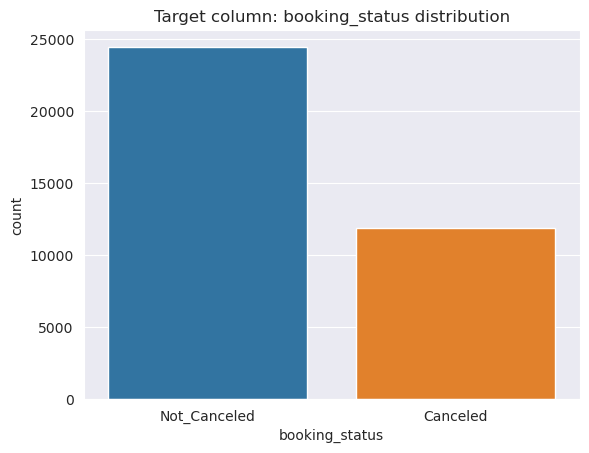

In [9]:
sns.set_style("darkgrid")
ax=sns.countplot(x=data_raw.booking_status)
ax.set_title('Target column: booking_status distribution')
plt.show()

In [10]:
data_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_adults,36275.0,1.844962,0.518715,0.0,2.0,2.00,2.0,4.0
no_of_children,36275.0,0.105279,0.402648,0.0,0.0,0.00,0.0,10.0
no_of_weekend_nights,36275.0,0.810724,0.870644,0.0,0.0,1.00,2.0,7.0
no_of_week_nights,36275.0,2.204300,1.410905,0.0,1.0,2.00,3.0,17.0
required_car_parking_space,36275.0,0.030986,0.173281,0.0,0.0,0.00,0.0,1.0
lead_time,36275.0,85.232557,85.930817,0.0,17.0,57.00,126.0,443.0
arrival_year,36275.0,2017.820427,0.383836,2017.0,2018.0,2018.00,2018.0,2018.0
arrival_month,36275.0,7.423653,3.069894,1.0,5.0,8.00,10.0,12.0
arrival_date,36275.0,15.596995,8.740447,1.0,8.0,16.00,23.0,31.0
repeated_guest,36275.0,0.025637,0.158053,0.0,0.0,0.00,0.0,1.0


In [11]:
data_raw.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Booking_ID,36275,36275,INN00001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
no_of_adults,36275.0,NaN,NaN,NaN,1.844962,0.518715,0.0,2.0,2.0,2.0,4.0
no_of_children,36275.0,NaN,NaN,NaN,0.105279,0.402648,0.0,0.0,0.0,0.0,10.0
no_of_weekend_nights,36275.0,NaN,NaN,NaN,0.810724,0.870644,0.0,0.0,1.0,2.0,7.0
no_of_week_nights,36275.0,NaN,NaN,NaN,2.2043,1.410905,0.0,1.0,2.0,3.0,17.0
type_of_meal_plan,36275,4,Meal Plan 1,27835,NaN,NaN,NaN,NaN,NaN,NaN,NaN
required_car_parking_space,36275.0,NaN,NaN,NaN,0.030986,0.173281,0.0,0.0,0.0,0.0,1.0
room_type_reserved,36275,7,Room_Type 1,28130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lead_time,36275.0,NaN,NaN,NaN,85.232557,85.930817,0.0,17.0,57.0,126.0,443.0
arrival_year,36275.0,NaN,NaN,NaN,2017.820427,0.383836,2017.0,2018.0,2018.0,2018.0,2018.0


## Feature Engineer

In [12]:
## the booking_id has no impact to the target class, so remove it
data_raw=data_raw.drop(columns='Booking_ID')

In [13]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          36275 non-null  int64  
 1   no_of_children                        36275 non-null  int64  
 2   no_of_weekend_nights                  36275 non-null  int64  
 3   no_of_week_nights                     36275 non-null  int64  
 4   type_of_meal_plan                     36275 non-null  object 
 5   required_car_parking_space            36275 non-null  int64  
 6   room_type_reserved                    36275 non-null  object 
 7   lead_time                             36275 non-null  int64  
 8   arrival_year                          36275 non-null  int64  
 9   arrival_month                         36275 non-null  int64  
 10  arrival_date                          36275 non-null  int64  
 11  market_segment_

In [14]:
data_raw[['type_of_meal_plan']]

,type_of_meal_plan
0,Meal Plan 1
1,Not Selected
2,Meal Plan 1
3,Meal Plan 1
4,Not Selected
...,...
36270,Meal Plan 1
36271,Meal Plan 1
36272,Meal Plan 1
36273,Not Selected


In [15]:
## As SVM, NN, KNN can't deal with category data, so do a one-hot encoding to transfer into binary columns:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
data_tmp=pd.DataFrame(enc.fit_transform(data_raw[['type_of_meal_plan']])).rename(columns={0:'tmp0',1:'tmp1',2:'tmp2',3:'tmp3'})
data_tmp

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,tmp0,tmp1,tmp2,tmp3
0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
36270,1.0,0.0,0.0,0.0
36271,1.0,0.0,0.0,0.0
36272,1.0,0.0,0.0,0.0
36273,0.0,0.0,0.0,1.0


In [16]:
data_rtr=pd.DataFrame(enc.fit_transform(data_raw[['room_type_reserved']])).rename(columns={0:'rtr0',1:'rtr1',2:'rtr2',3:'rtr3',4:'rtr4',5:'rtr5',6:'rtr6'})
data_rtr.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,rtr0,rtr1,rtr2,rtr3,rtr4,rtr5,rtr6
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
data_mst=pd.DataFrame(enc.fit_transform(data_raw[['market_segment_type']])).rename(columns={0:'mst0',1:'mst1',2:'mst2',3:'mst3',4:'mst4'})
data_mst

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,mst0,mst1,mst2,mst3,mst4
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
36270,0.0,0.0,0.0,0.0,1.0
36271,0.0,0.0,0.0,0.0,1.0
36272,0.0,0.0,0.0,0.0,1.0
36273,0.0,0.0,0.0,0.0,1.0


In [18]:
data=data_raw.join(data_mst).join(data_rtr).join(data_tmp)
data.drop(columns=(['type_of_meal_plan','room_type_reserved','market_segment_type']),inplace=True)
data.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,...,rtr1,rtr2,rtr3,rtr4,rtr5,rtr6,tmp0,tmp1,tmp2,tmp3
0,2,0,1,2,0,224,2017,10,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,0,2,3,0,5,2018,11,6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,0,2,1,0,1,2018,2,28,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2,0,0,2,0,211,2018,5,20,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2,0,1,1,0,48,2018,4,11,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Modelling

### Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [24]:
data.columns

Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space', 'lead_time',
       'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status',
       'mst0', 'mst1', 'mst2', 'mst3', 'mst4', 'rtr0', 'rtr1', 'rtr2', 'rtr3',
       'rtr4', 'rtr5', 'rtr6', 'tmp0', 'tmp1', 'tmp2', 'tmp3'],
      dtype='object')

In [25]:
Y=data['booking_status']
X=data.loc[:,data.columns!='booking_status']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [26]:
clf=DecisionTreeClassifier()
clf=clf.fit(X_train,Y_train)
Y_pred_train=clf.predict(X_train)

In [27]:
train_f1=metrics.f1_score(Y_train,Y_pred_train,average='micro')
train_f1

0.994210775047259

In [28]:
Y_pred=clf.predict(X_test)
test_f1=metrics.f1_score(Y_test,Y_pred,average='micro')
test_f1

0.8711752274189102

In [29]:
## Since data is imbalanced, we will chose "macro" for f1_score which gives bigger penalty if model does not perform well for minority class
metrics.f1_score(Y_test,Y_pred,average='macro')

0.8537663874401589

In [30]:
## micro not faving in any class
metrics.f1_score(Y_test,Y_pred,average='micro')

0.8711752274189102

In [31]:
## wighted will give more weight for majority class which is not good for imbalanced data
metrics.f1_score(Y_test,Y_pred,average='weighted')

0.8715646661827491

#### parameters to explore

In [384]:
train_scores=[]
test_scores=[]
for i in range(1, 21):
    model = DecisionTreeClassifier(max_depth=i)
    model.fit(X_train,Y_train)
    train_pred = model.predict(X_train)
    train_f1 = metrics.f1_score(Y_train,train_pred ,average='micro') 
    train_scores.append(train_f1)

    test_pred = model.predict(X_test)
    test_f1 = metrics.f1_score(Y_test,test_pred ,average='micro') 
    test_scores.append(test_f1)

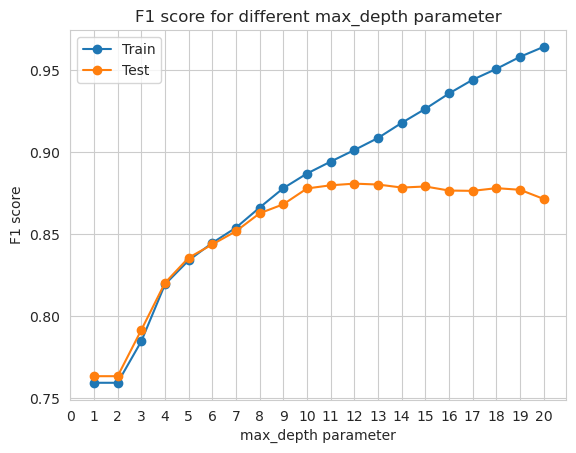

In [391]:
plt.plot(range(1,21), train_scores, '-o', label='Train')
plt.plot(range(1,21), test_scores, '-o', label='Test')
plt.title('F1 score for different max_depth parameter')
plt.xlabel('max_depth parameter')
plt.ylabel('F1 score')
plt.xticks(np.arange(0, 21, step=1))
plt.legend()
plt.show()

In [398]:
train_scores=[]
test_scores=[]
values=range(2,15)
for i in values:
    model = DecisionTreeClassifier(min_samples_split=i)
    model.fit(X_train,Y_train)
    train_pred = model.predict(X_train)
    train_f1 = metrics.f1_score(Y_train,train_pred ,average='micro') 
    train_scores.append(train_f1)

    test_pred = model.predict(X_test)
    test_f1 = metrics.f1_score(Y_test,test_pred ,average='micro') 
    test_scores.append(test_f1)

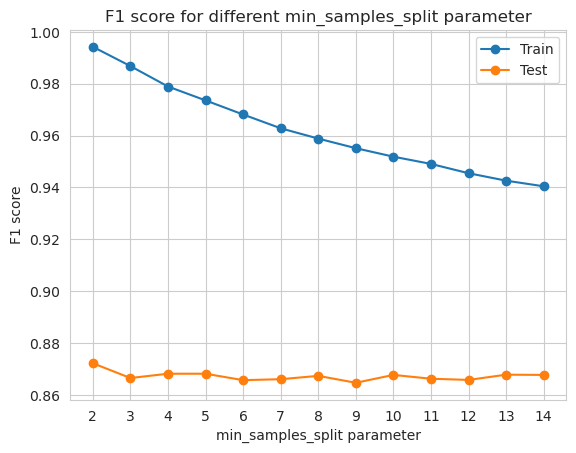

In [399]:
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.title('F1 score for different min_samples_split parameter')
plt.xlabel('min_samples_split parameter')
plt.ylabel('F1 score')
plt.xticks(np.arange(2, 15, step=1))
plt.legend()
plt.show()

#### GridSearch for the best parameters

In [402]:
dt_param_grid = {"criterion": ['gini','entropy'],
              "max_depth": [None,5,10,15, 20],
              "min_samples_split": [0,2,3,5,20]
              }

In [403]:
clf_GS = GridSearchCV(estimator=clf, param_grid=dt_param_grid,cv=5, scoring='f1_micro', return_train_score=True)
clf1=clf_GS.fit(X_train,Y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
50 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py", line 637, in _valida

In [405]:
clf1.best_score_

0.8732669586581636

In [404]:
clf1.best_params_

{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 2}

In [411]:
dc_gts=pd.DataFrame(clf1.cv_results_).reset_index()
dc_gts.head()

,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,0.002718,0.000205,0.000000,0.000000,gini,None,0,"{'criterion': 'gini', 'max_depth': None, 'min_...",NaN,...,NaN,NaN,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.124001,0.002038,0.043064,0.000538,gini,None,2,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.861981,...,0.860744,0.002664,27,0.994142,0.994782,0.994634,0.994634,0.994782,0.994595,0.000236
2,2,0.124378,0.001048,0.042955,0.000602,gini,None,3,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.860012,...,0.858735,0.003737,30,0.985970,0.986659,0.986659,0.987496,0.987201,0.986797,0.000524
3,3,0.118272,0.002346,0.043231,0.000721,gini,None,5,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.858240,...,0.856845,0.004256,32,0.973416,0.972825,0.972039,0.974008,0.973516,0.973161,0.000675
4,4,0.110983,0.000720,0.043036,0.000555,gini,None,20,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.865328,...,0.859956,0.004341,29,0.926106,0.924876,0.923993,0.925076,0.926356,0.925282,0.000860


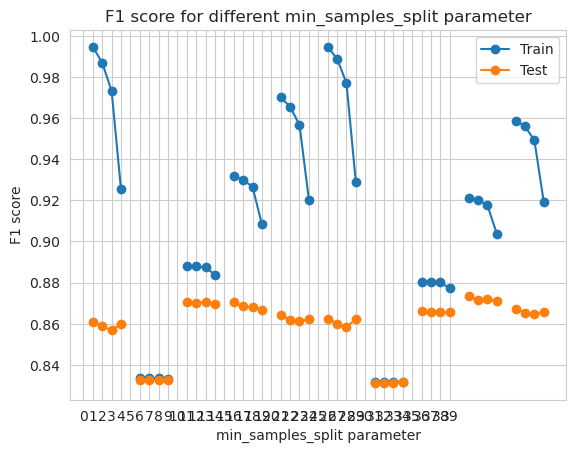

In [419]:
plt.plot(dc_gts['index'], dc_gts['mean_train_score'], '-o', label='Train')
plt.plot(dc_gts['index'], dc_gts['mean_test_score'], '-o', label='Test')
plt.title('F1 score for different min_samples_split parameter')
plt.xlabel('min_samples_split parameter')
plt.ylabel('F1 score')
plt.xticks(np.arange(0,40, step=1))
plt.legend()
plt.show()

In [60]:
## find the parameter
dt_param_grid = {"criterion": ['gini','entropy'],
              "max_depth": [None,5,10,13,15, 17, 20],
              "min_samples_split": [0,1,2,3,5,10]
              }

In [61]:
clf_GS = GridSearchCV(estimator=clf, param_grid=dt_param_grid,cv=5, scoring='f1_micro', return_train_score=True)
clf1=clf_GS.fit(X_train,Y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
140 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py", line 637, in _valid

In [62]:
clf1.best_score_

0.8731093930548767

In [63]:
clf1.best_params_

{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 2}

## Boosting

#### Adaboost

In [423]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

In [433]:
clf_boost = AdaBoostClassifier(n_estimators=100).fit(X_train, Y_train)
Y_pred_boost1=clf_boost.predict(X_test)

In [435]:
metrics.f1_score(Y_test,Y_pred_boost1,average='micro')

0.8226591932371589

In [447]:
train_scores=[]
test_scores=[]
values=range(10,300,20)
for i in values:
    model = AdaBoostClassifier(n_estimators=i)
    model.fit(X_train,Y_train)
    train_pred = model.predict(X_train)
    train_f1 = metrics.f1_score(Y_train,train_pred ,average='micro') 
    train_scores.append(train_f1)

    test_pred = model.predict(X_test)
    test_f1 = metrics.f1_score(Y_test,test_pred ,average='micro') 
    test_scores.append(test_f1)

In [444]:
min(values)

10

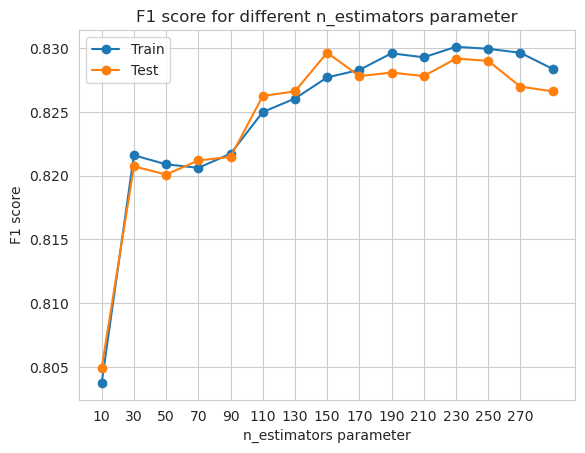

In [448]:
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.title('F1 score for different n_estimators parameter')
plt.xlabel('n_estimators parameter')
plt.ylabel('F1 score')
plt.xticks(np.arange(min(values), max(values), step=20))
plt.legend()
plt.show()

In [452]:
train_scores=[]
test_scores=[]
values=[0.1,0.5,1,5,10]
for i in values:
    model = AdaBoostClassifier(learning_rate=i)
    model.fit(X_train,Y_train)
    train_pred = model.predict(X_train)
    train_f1 = metrics.f1_score(Y_train,train_pred ,average='micro') 
    train_scores.append(train_f1)

    test_pred = model.predict(X_test)
    test_f1 = metrics.f1_score(Y_test,test_pred ,average='micro') 
    test_scores.append(test_f1)

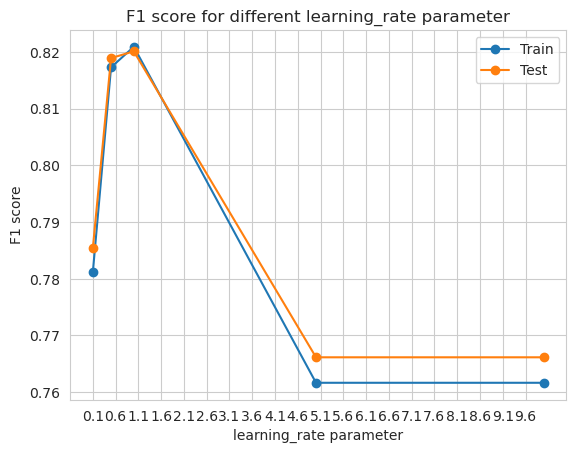

In [454]:
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.title('F1 score for different learning_rate parameter')
plt.xlabel('learning_rate parameter')
plt.ylabel('F1 score')
plt.xticks(np.arange(min(values), max(values), step=0.5))
plt.legend()
plt.show()

In [468]:
boost_param= {
    "n_estimators": [50,100,150,200],
    "learning_rate":[0.1,0.5,1,5,10]
}

In [469]:
clf_GS = GridSearchCV(estimator=clf_boost, param_grid=boost_param,cv=5, scoring='f1_micro', return_train_score=True)
clf_boost_GS=clf_GS.fit(X_train,Y_train)

In [471]:
clf_boost_GS.best_params_

{'learning_rate': 1, 'n_estimators': 150}

In [474]:
Y_pred_boost3=clf_boost_GS.predict(X_test)

In [475]:
metrics.f1_score(Y_test,Y_pred_boost3,average='micro')

0.8296425617936231

#### Gradient Boosting

In [476]:
clf_boost2 = GradientBoostingClassifier().fit(X_train, Y_train)
Y_pred_boost2=clf_boost2.predict(X_test)

In [478]:
metrics.f1_score(Y_test,Y_pred_boost2,average='micro')

0.8525222824588807

In [486]:
train_scores=[]
test_scores=[]
values=[0.1,0.5,1.0,5.0]
for i in values:
    model =  GradientBoostingClassifier(learning_rate=i).fit(X_train, Y_train)
    model.fit(X_train,Y_train)
    train_pred = model.predict(X_train)
    train_f1 = metrics.f1_score(Y_train,train_pred ,average='micro') 
    train_scores.append(train_f1)

    test_pred = model.predict(X_test)
    test_f1 = metrics.f1_score(Y_test,test_pred ,average='micro') 
    test_scores.append(test_f1)

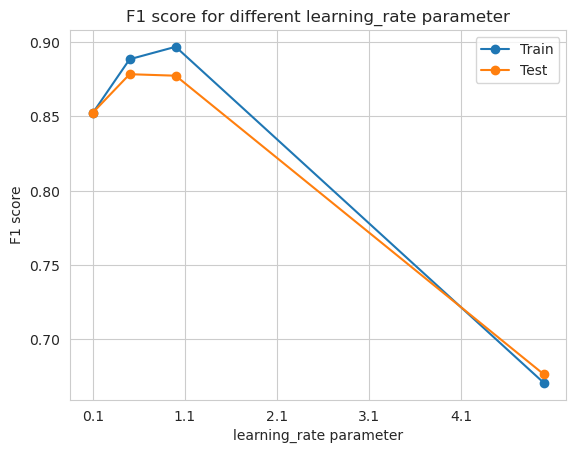

In [487]:
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.title('F1 score for different learning_rate parameter')
plt.xlabel('learning_rate parameter')
plt.ylabel('F1 score')
plt.xticks(np.arange(min(values), max(values)))
plt.legend()
plt.show()

In [491]:
train_scores=[]
test_scores=[]
values=[3,5,10,20,30,40]
for i in values:
    model =  GradientBoostingClassifier(max_depth=i).fit(X_train, Y_train)
    model.fit(X_train,Y_train)
    train_pred = model.predict(X_train)
    train_f1 = metrics.f1_score(Y_train,train_pred ,average='micro') 
    train_scores.append(train_f1)

    test_pred = model.predict(X_test)
    test_f1 = metrics.f1_score(Y_test,test_pred ,average='micro') 
    test_scores.append(test_f1)

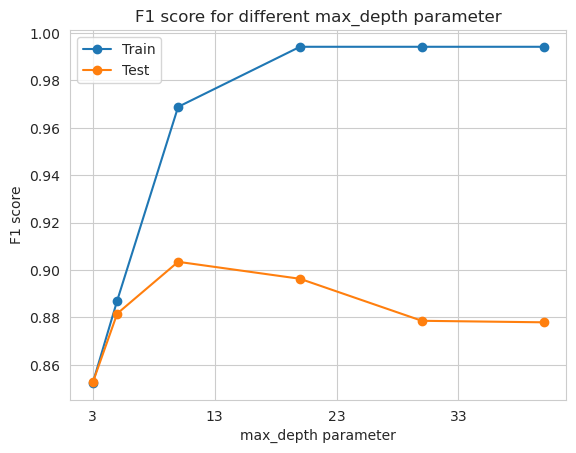

In [494]:
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.title('F1 score for different max_depth parameter')
plt.xlabel('max_depth parameter')
plt.ylabel('F1 score')
plt.xticks(np.arange(min(values), max(values),10))
plt.legend()
plt.show()

In [500]:
train_scores=[]
test_scores=[]
values=[100,150,200,250,300,350,400,450,500]
for i in values:
    model = GradientBoostingClassifier(n_estimators=i).fit(X_train, Y_train)
    model.fit(X_train,Y_train)
    train_pred = model.predict(X_train)
    train_f1 = metrics.f1_score(Y_train,train_pred ,average='micro') 
    train_scores.append(train_f1)

    test_pred = model.predict(X_test)
    test_f1 = metrics.f1_score(Y_test,test_pred ,average='micro') 
    test_scores.append(test_f1)

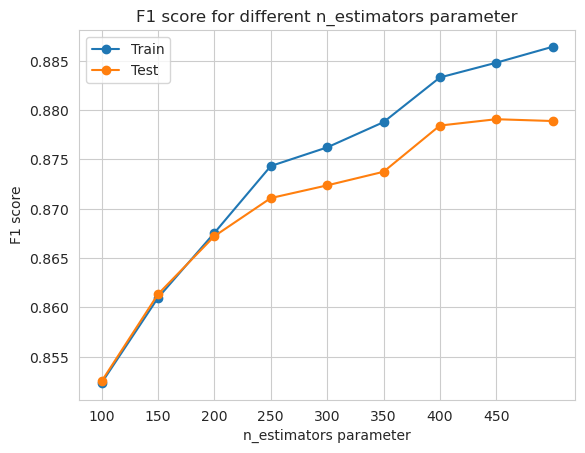

In [501]:
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.title('F1 score for different n_estimators parameter')
plt.xlabel('n_estimators parameter')
plt.ylabel('F1 score')
plt.xticks(np.arange(min(values), max(values),50))
plt.legend()
plt.show()

In [502]:
## change the max_depth to 20, and learning rate to 0.01 and 10, best learning rate =1
clf_boost2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=20, random_state=0).fit(X_train, Y_train)


In [503]:
Y_pred_boost2=clf_boost2.predict(X_test)

In [504]:
metrics.f1_score(Y_test,Y_pred_boost2,average='micro')

0.9013139759257558

In [508]:
Gboost_param= {
    "n_estimators": [100,200,300,400],
    "learning_rate":[0.1,1,10],
    "max_depth":[10, 20, 30, 40]
}

In [ ]:
clf_GS = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=Gboost_param,cv=5, scoring='f1_micro', return_train_score=True)
clf_boost_GS=clf_GS.fit(X_train, Y_train)

In [505]:
clf_boost3 = GradientBoostingClassifier(n_estimators=450, learning_rate=1, max_depth=10, random_state=0).fit(X_train, Y_train)

In [506]:
Y_pred_boost3=clf_boost3.predict(X_test)
metrics.f1_score(Y_test,Y_pred_boost3,average='micro')

0.8969953137921529

#### XGBoost

In [88]:
!/home/ec2-user/anaconda3/envs/python3/bin/python3 -m pip install  xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/c1/cf/a662bc8f40588d54663edfe12980946670490bff0b6e793c7896a4fe36df/xgboost-2.0.0-py3-none-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 4.0 MB/s eta 0:00:00:00:0100:01


In [90]:
from xgboost import XGBClassifier

In [98]:
Y_train_boost3=np.where(Y_train=='Canceled',1,0)
Y_test_boost3=np.where(Y_test=='Canceled',1,0)

In [96]:
clf_boost3 = XGBClassifier()
clf_boost3.fit(X_train, Y_train_boost3)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [119]:
Y_pred_boost3=clf_boost3.predict(X_test)

In [127]:
metrics.f1_score(Y_pred_boost3,Y_test_boost3,average='micro')

0.8939630616557934

### KNN
knn need apply x and y in array format, so it needs train on X_train.values

In [169]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train.values, Y_train.values)

KNeighborsClassifier(n_neighbors=1)

In [170]:
y_pred_knn=knn.predict(X_test.values)

In [171]:
metrics.f1_score(y_pred_knn,Y_test,average='micro')

0.8131030046862078

#### find the best parameter for KNN

In [516]:
train_scores=[]
test_scores=[]
values=range(1,30)
for i in values:
    model =  KNeighborsClassifier(n_neighbors=i).fit(X_train.values, Y_train.values)
    train_pred = model.predict(X_train.values)
    train_f1 = metrics.f1_score(Y_train,train_pred ,average='micro') 
    train_scores.append(train_f1)
    test_pred = model.predict(X_test.values)
    test_f1 = metrics.f1_score(Y_test,test_pred ,average='micro') 
    test_scores.append(test_f1)

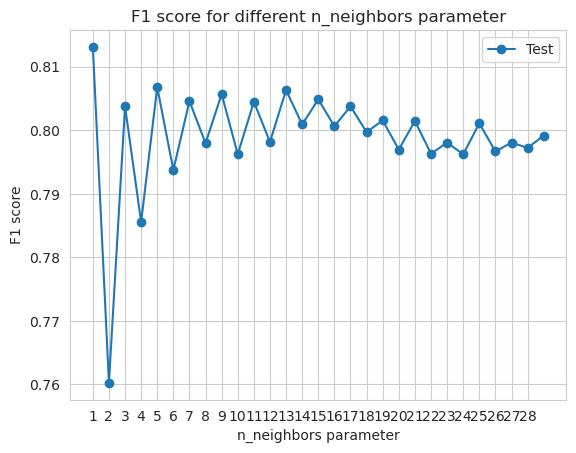

In [518]:

plt.plot(values, test_scores, '-o', label='Test')
plt.title('F1 score for different n_neighbors parameter')
plt.xlabel('n_neighbors parameter')
plt.ylabel('F1 score')
plt.xticks(np.arange(min(values), max(values)))
plt.legend()
plt.show()

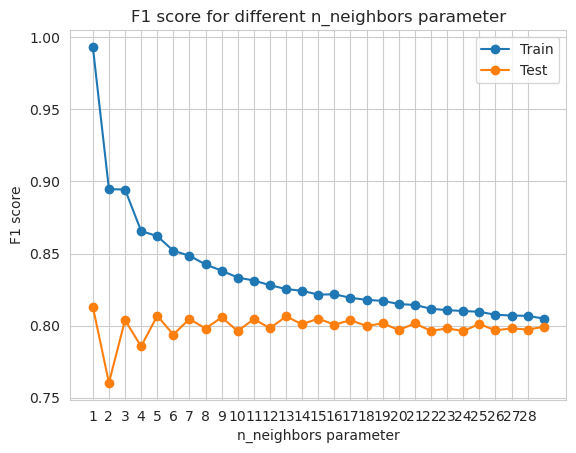

In [517]:
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.title('F1 score for different n_neighbors parameter')
plt.xlabel('n_neighbors parameter')
plt.ylabel('F1 score')
plt.xticks(np.arange(min(values), max(values)))
plt.legend()
plt.show()

In [519]:
model =  KNeighborsClassifier(n_neighbors=5).fit(X_train.values, Y_train.values)
test_pred = model.predict(X_test.values)
metrics.f1_score(Y_test,test_pred ,average='micro')

0.8067628411283654

#### gridsearch

In [173]:
parameters = {"n_neighbors": range(1, 10)}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters,scoring='f1_micro',return_train_score=True)

In [174]:
gridsearch.fit(X_train.values, Y_train.values)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 10)}, return_train_score=True,
             scoring='f1_micro')

In [175]:
gridsearch.best_params_["n_neighbors"]

5

In [177]:
gridsearch.best_estimator_

KNeighborsClassifier()

In [178]:
y_pred_knn_GS=gridsearch.predict(X_test.values)

In [179]:
metrics.f1_score(y_pred_knn_GS,Y_test,average='micro')

0.8067628411283654

In [180]:
gridsearch.best_score_

0.8000550498655314

In [176]:
gridsearch.cv_results_

{'mean_fit_time': array([0.02305908, 0.02271485, 0.02264342, 0.02266974, 0.02245784,
        0.02271099, 0.02262335, 0.02247572, 0.02254877]),
 'std_fit_time': array([0.00035102, 0.00053674, 0.00039017, 0.00020923, 0.00023705,
        0.00036227, 0.00026741, 0.00031071, 0.00030518]),
 'mean_score_time': array([0.36640654, 0.36764674, 0.36785493, 0.36749654, 0.36761441,
        0.3692277 , 0.37375541, 0.37074723, 0.370331  ]),
 'std_score_time': array([0.00344888, 0.00414707, 0.00252515, 0.00385845, 0.00303373,
        0.00424874, 0.00719387, 0.00508477, 0.00114669]),
 'param_n_neighbors': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1},
  {'n_neighbors': 2},
  {'n_neighbors': 3},
  {'n_neighbors': 4},
  {'n_neighbors': 5},
  {'n_neighbors': 6},
  {'n_neighbors': 7},
  {'n_neighbors': 8},
  {'n_neighbors

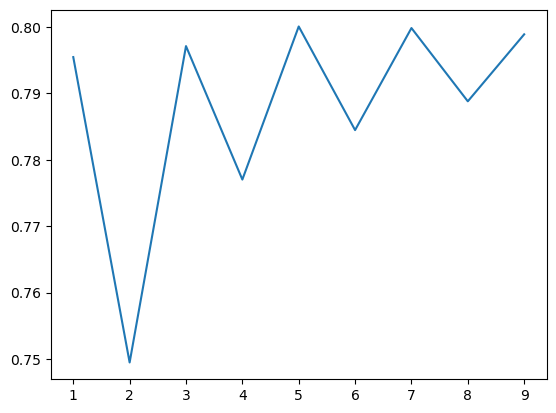

In [203]:
plt.plot(range(1,10),gridsearch.cv_results_['mean_test_score'])

### SVM

In [67]:
from sklearn import svm
svc =svm.SVC(kernel='linear') 

In [68]:
svc.fit(X_train, Y_train)

SVC(kernel='linear')

In [69]:
Y_pred_svc=svc.predict(X_test)
metrics.f1_score(Y_pred_svc,Y_test,average='micro')

0.803914361848755

In [73]:
## use cross validation to check the data
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svc, X_train, Y_train, cv=5)

In [74]:
scores

array([0.80645796, 0.80271707, 0.80681371, 0.80602599, 0.79598267])

In [75]:
parameters = {'kernel':('linear', 'rbf','sigmoid'), 
              'C':[0.1, 1, 10],'gamma': [1,0.1,0.01]}
svc_GS= GridSearchCV(svc, parameters)

In [76]:
parameters = {'kernel':('linear', 'rbf','sigmoid'), 
              'C':[0.1, 1, 10]}
svc_GS= GridSearchCV(svc, parameters)

In [ ]:
svc_GS.fit(X_train, Y_train)

In [ ]:
svc_GS.best_params_

In [213]:
gridsearch.best_score_

0.8000550498655314

In [216]:
y_pred_svc_GS=gridsearch.predict(X_test.values)

In [217]:
metrics.f1_score(y_pred_svc_GS,Y_test,average='micro')

0.8067628411283654

In [212]:
svc_GS.cv_results_

{'mean_fit_time': array([29.98484626, 25.49283214, 31.13745656, 25.66927733]),
 'std_fit_time': array([4.13201075, 0.12150613, 3.93186123, 0.16520814]),
 'mean_score_time': array([0.97192316, 5.14349437, 0.97602367, 5.0350636 ]),
 'std_score_time': array([0.01306648, 0.01892054, 0.01426088, 0.01328559]),
 'param_C': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['linear', 'rbf', 'linear', 'rbf'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1, 'kernel': 'linear'},
  {'C': 1, 'kernel': 'rbf'},
  {'C': 10, 'kernel': 'linear'},
  {'C': 10, 'kernel': 'rbf'}],
 'split0_test_score': array([0.80330774, 0.76885214, 0.80409529, 0.7641268 ]),
 'split1_test_score': array([0.79582595, 0.76314235, 0.79503839, 0.75940146]),
 'split2_test_score': array([0.80445057, 0.76112643, 0.80543521, 0.75088618]),
 's

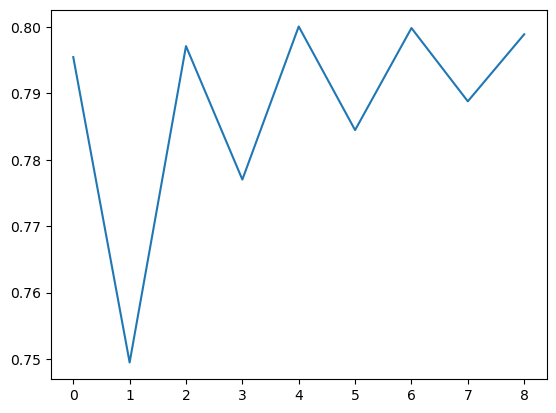

In [220]:
plt.plot(gridsearch.cv_results_['mean_test_score'])

### NN 
keras

In [20]:
!pip install tensorflow

In [36]:
import tensorflow as tf

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [33]:
## Need scale before NN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)  

In [39]:
Y_train_boost3=np.where(Y_train=='Canceled',1,0)
Y_test_boost3=np.where(Y_test=='Canceled',1,0)

In [34]:
model = Sequential()
model.add(Dense(12, input_shape=(30,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

2023-09-24 14:38:09.202383: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [41]:
model.compile(loss='binary_crossentropy',optimizer='sgd', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.fit(X_train, Y_train_boost3,epochs=10, batch_size=1, verbose=1)

Epoch 1/10
25392/25392 [==============================] - 35s 1ms/step - loss: 0.4088 - accuracy: 0.8121 - recall_2: 0.6422 - precision_2: 0.7511
Epoch 2/10
25392/25392 [==============================] - 34s 1ms/step - loss: 0.3940 - accuracy: 0.8219 - recall_2: 0.6476 - precision_2: 0.7746
Epoch 3/10
25392/25392 [==============================] - 34s 1ms/step - loss: 0.3809 - accuracy: 0.8283 - recall_2: 0.6660 - precision_2: 0.7803
Epoch 4/10
25392/25392 [==============================] - 34s 1ms/step - loss: 0.3732 - accuracy: 0.8335 - recall_2: 0.6762 - precision_2: 0.7882
Epoch 5/10
25392/25392 [==============================] - 34s 1ms/step - loss: 0.3702 - accuracy: 0.8340 - recall_2: 0.6769 - precision_2: 0.7892
Epoch 6/10
25392/25392 [==============================] - 34s 1ms/step - loss: 0.3671 - accuracy: 0.8377 - recall_2: 0.6828 - precision_2: 0.7955
Epoch 7/10
25392/25392 [==============================] - 34s 1ms/step - loss: 0.3658 - accuracy: 0.8366 - recall_2: 0.6794 

In [43]:
score = model.evaluate(X_test, Y_test_boost3,verbose=1)

341/341 [==============================] - 1s 1ms/step - loss: 0.3665 - accuracy: 0.8427 - recall_2: 0.7141 - precision_2: 0.7811


In [45]:
y_pred_nn = model.predict(X_test)
y_pred_test_nn=np.where(y_pred_nn>0.5,1,0)
metrics.f1_score(y_pred_test_nn ,Y_test_boost3,average='micro')

0.8426904346228062

In [46]:
model = Sequential()
model.add(Dense(12, input_shape=(30,), activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='sgd', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.fit(X_train, Y_train_boost3,epochs=10, batch_size=1, verbose=1)

In [48]:
y_pred_nn = model.predict(X_test)
y_pred_test_nn=np.where(y_pred_nn>0.5,1,0)
metrics.f1_score(y_pred_test_nn ,Y_test_boost3,average='micro')

341/341 [==============================] - 0s 1ms/step


0.8327667003583572

In [55]:
model = Sequential()
model.add(Dense(8, input_shape=(30,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [62]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 8)                 248       
                                                                 
 dense_14 (Dense)            (None, 8)                 72        
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
model.compile(loss='binary_crossentropy',optimizer='sgd', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.fit(X_train, Y_train_boost3,epochs=10, batch_size=1, verbose=1)

Epoch 1/10
25392/25392 [==============================] - 35s 1ms/step - loss: 0.3800 - accuracy: 0.8242 - recall_8: 0.6580 - precision_8: 0.7743
Epoch 2/10
25392/25392 [==============================] - 35s 1ms/step - loss: 0.3789 - accuracy: 0.8250 - recall_8: 0.6579 - precision_8: 0.7767
Epoch 3/10
25392/25392 [==============================] - 35s 1ms/step - loss: 0.3781 - accuracy: 0.8238 - recall_8: 0.6494 - precision_8: 0.7789
Epoch 4/10
25392/25392 [==============================] - 34s 1ms/step - loss: 0.3773 - accuracy: 0.8256 - recall_8: 0.6532 - precision_8: 0.7814
Epoch 5/10
25392/25392 [==============================] - 34s 1ms/step - loss: 0.3760 - accuracy: 0.8282 - recall_8: 0.6633 - precision_8: 0.7819
Epoch 6/10
25392/25392 [==============================] - 35s 1ms/step - loss: 0.3751 - accuracy: 0.8295 - recall_8: 0.6579 - precision_8: 0.7894
Epoch 7/10
25392/25392 [==============================] - 34s 1ms/step - loss: 0.3730 - accuracy: 0.8283 - recall_8: 0.6611 

In [60]:
y_pred_nn = model.predict(X_test)
y_pred_test_nn=np.where(y_pred_nn>0.5,1,0)
metrics.f1_score(y_pred_test_nn ,Y_test_boost3,average='micro')

341/341 [==============================] - 0s 1ms/step


0.8345125424974731

In [52]:
model = Sequential()
model.add(Dense(8, input_shape=(30,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [53]:
model.compile(loss='binary_crossentropy',optimizer='sgd', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.fit(X_train, Y_train_boost3,epochs=5, batch_size=1, verbose=1)

Epoch 1/5
25392/25392 [==============================] - 36s 1ms/step - loss: 0.4480 - accuracy: 0.7906 - recall_6: 0.5998 - precision_6: 0.7181
Epoch 2/5
25392/25392 [==============================] - 35s 1ms/step - loss: 0.4124 - accuracy: 0.8093 - recall_6: 0.6269 - precision_6: 0.7528
Epoch 3/5
25392/25392 [==============================] - 35s 1ms/step - loss: 0.3995 - accuracy: 0.8168 - recall_6: 0.6298 - precision_6: 0.7719
Epoch 4/5
25392/25392 [==============================] - 35s 1ms/step - loss: 0.3935 - accuracy: 0.8189 - recall_6: 0.6369 - precision_6: 0.7733
Epoch 5/5
25392/25392 [==============================] - 35s 1ms/step - loss: 0.3872 - accuracy: 0.8242 - recall_6: 0.6592 - precision_6: 0.7735


In [54]:
y_pred_nn = model.predict(X_test)
y_pred_test_nn=np.where(y_pred_nn>0.5,1,0)
metrics.f1_score(y_pred_test_nn ,Y_test_boost3,average='micro')

341/341 [==============================] - 0s 1ms/step


0.8242212625195259

In [63]:
model = Sequential()
model.add(Dense(12, input_shape=(30,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [64]:
model.compile(loss='binary_crossentropy',optimizer='sgd', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.fit(X_train, Y_train_boost3,epochs=10, batch_size=1, verbose=1)

Epoch 1/10
25392/25392 [==============================] - 35s 1ms/step - loss: 0.4208 - accuracy: 0.8056 - recall_9: 0.6270 - precision_9: 0.7427
Epoch 2/10
25392/25392 [==============================] - 35s 1ms/step - loss: 0.3911 - accuracy: 0.8208 - recall_9: 0.6670 - precision_9: 0.7595
Epoch 3/10
25392/25392 [==============================] - 34s 1ms/step - loss: 0.3797 - accuracy: 0.8262 - recall_9: 0.6707 - precision_9: 0.7717
Epoch 4/10
25392/25392 [==============================] - 34s 1ms/step - loss: 0.3717 - accuracy: 0.8324 - recall_9: 0.6870 - precision_9: 0.7782
Epoch 5/10
25392/25392 [==============================] - 35s 1ms/step - loss: 0.3677 - accuracy: 0.8320 - recall_9: 0.6789 - precision_9: 0.7823
Epoch 6/10
25392/25392 [==============================] - 35s 1ms/step - loss: 0.3657 - accuracy: 0.8347 - recall_9: 0.6859 - precision_9: 0.7851
Epoch 7/10
25392/25392 [==============================] - 35s 1ms/step - loss: 0.3633 - accuracy: 0.8359 - recall_9: 0.6815 

In [66]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 12)                372       
                                                                 
 dense_17 (Dense)            (None, 32)                416       
                                                                 
 dense_18 (Dense)            (None, 1)                 33        
                                                                 
Total params: 821 (3.21 KB)
Trainable params: 821 (3.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
y_pred_nn = model.predict(X_test)
y_pred_test_nn=np.where(y_pred_nn>0.5,1,0)
metrics.f1_score(y_pred_test_nn ,Y_test_boost3,average='micro')

341/341 [==============================] - 0s 1ms/step


0.8337774510704768